In [40]:
import torch
import torchaudio

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


In [41]:
def convert_to_wav(path: str, target_sr: int = 16000, mono: bool = True) -> str:
    """
    m4a/mp3 등 어떤 포맷이 와도 ffmpeg로 16kHz/mono WAV로 변환.
    반환: 변환된 임시 WAV 경로
    """
    tmp_wav = tempfile.NamedTemporaryFile(suffix=".wav", delete=False).name
    cmd = ["ffmpeg", "-y", "-i", path]
    if target_sr: cmd += ["-ar", str(target_sr)]
    if mono: cmd += ["-ac", "1"]
    cmd += [tmp_wav]
    # ffmpeg 출력 숨김
    subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return tmp_wav

def load_audio_any(path: str, target_sr: int = 16000):
    """
    어떤 입력이 와도 convert_to_wav로 16kHz/mono WAV로 바꾼 다음 torchaudio.load.
    반환: (waveform[Torch: [1, T]], sample_rate, wav_path)
    """
    wav_path = convert_to_wav(path, target_sr=target_sr, mono=True)
    waveform, sr = torchaudio.load(wav_path)  # [channels=1, time]
    return waveform, sr, wav_path

In [42]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = "./source.mp3"  


In [43]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [44]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [45]:
IPython.display.Audio(SPEECH_FILE)

In [46]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

/opt/anaconda3/envs/ai_lab/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [47]:
labels = bundle.get_labels()
target_sr = bundle.sample_rate  # 16000

In [48]:
import tempfile, subprocess
import IPython.display as ipd 

# 1) 로드 (항상 16kHz mono WAV로 변환 뒤 로드됨)
waveform, sample_rate, tmp_wav = load_audio_any(SPEECH_FILE, target_sr=target_sr)

# 2) (선택) 재생
display(ipd.Audio(tmp_wav))

# 3) 디바이스로 이동
waveform = waveform.to(device)

/opt/anaconda3/envs/ai_lab/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [49]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

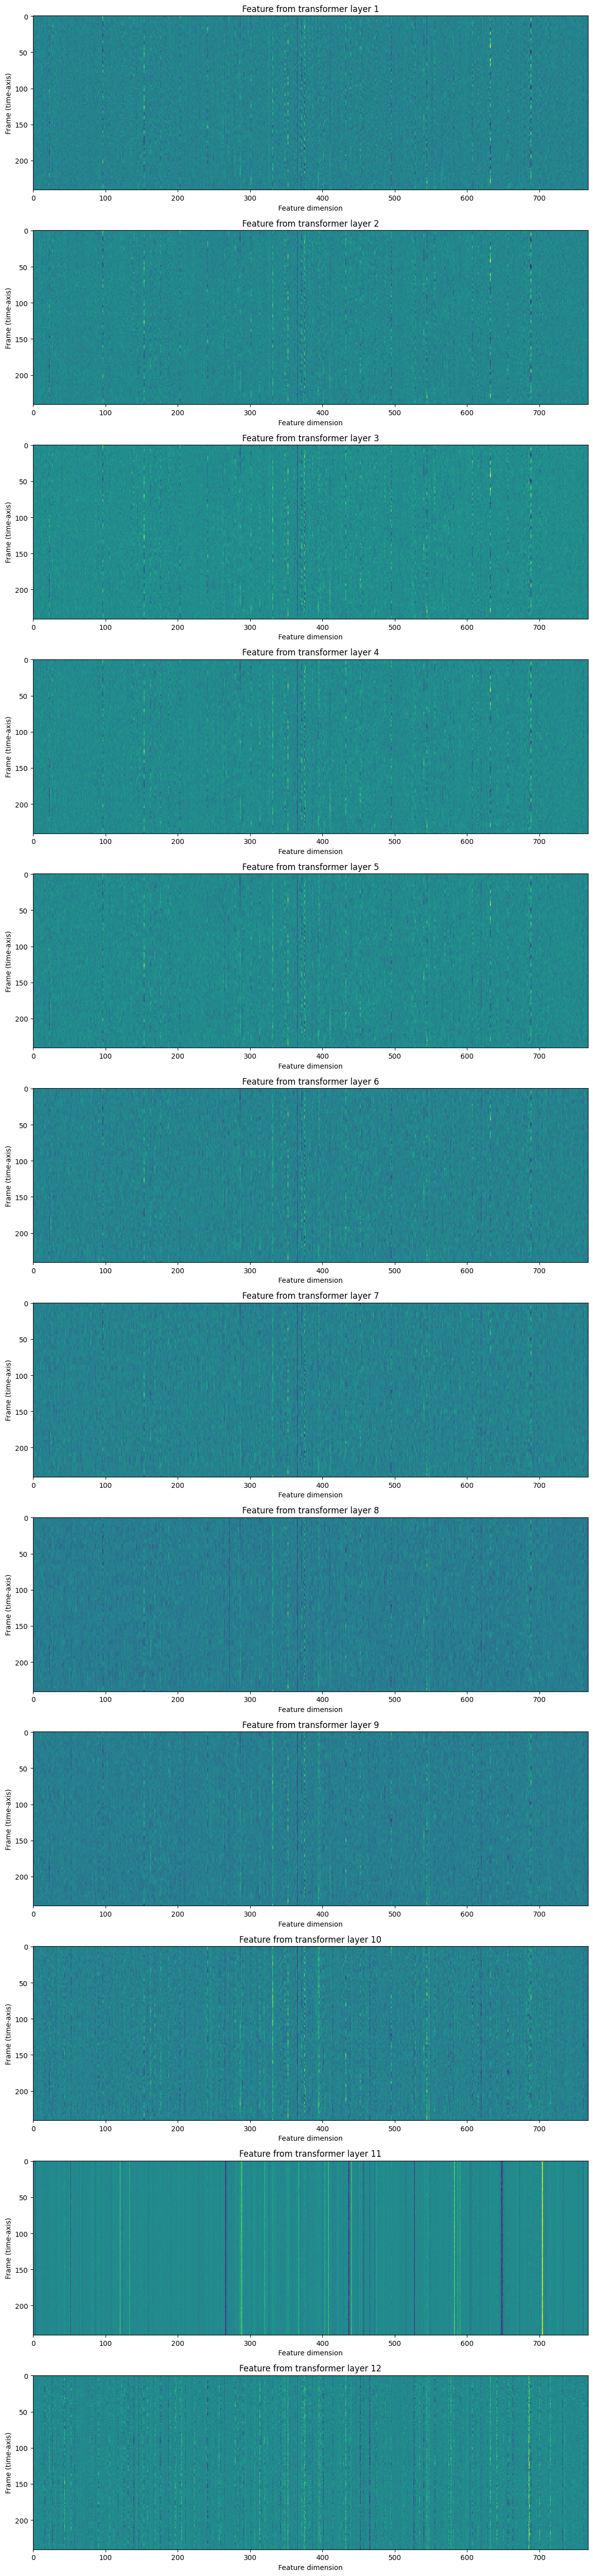

In [50]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [51]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


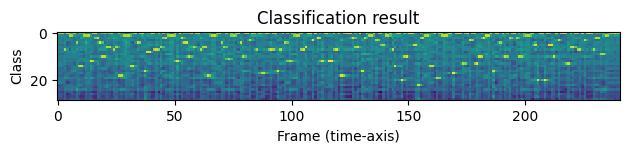

In [52]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [53]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [54]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [55]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|AM|LEARNING|MACHINE|LEARNING|AND|ARTIFICIAL|INTELLIGENCE|TO|IMPROVE|MY|FUTURE|CAREER|OPPORTUNITIES|


In [32]:
!pip install jiwer librosa soxr

Audio file loaded and preprocessed successfully.


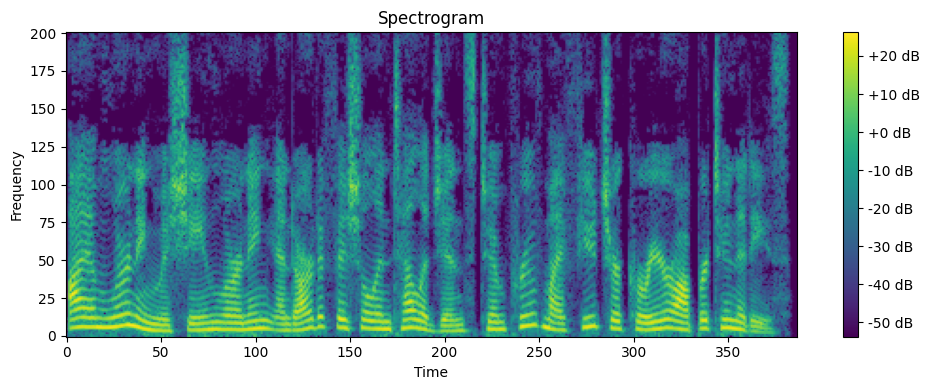

/opt/anaconda3/envs/ai_lab/lib/python3.10/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


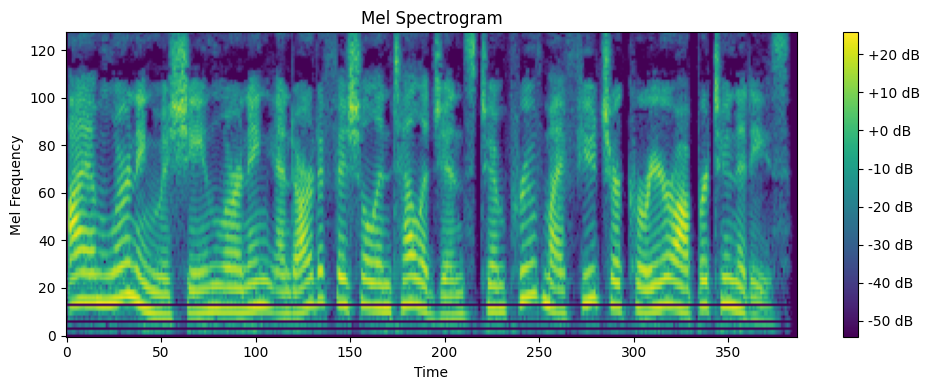

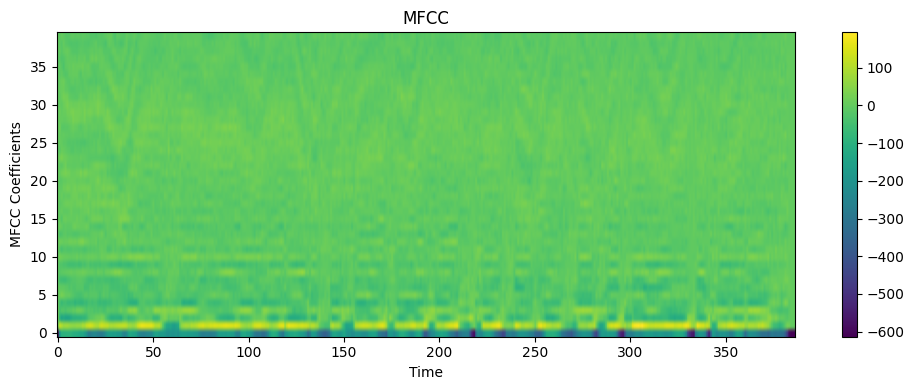

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/opt/anaconda3/envs/ai_lab/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


------------------------------
Reference Transcript : I AM LEARNING MACHINE LEARNING AND ARTIFICIAL INTELLIGENCE TO IMPROVE MY FUTURE CAREER OPPORTUNITIES
Predicted Transcript : I AM LEARNING MACHINE LEARNING AND ARTIFICIAL INTELLIGENCE TO IMPROVE MY FUTURE CAREER OPPORTUNITIES
------------------------------
Word Error Rate (WER): 0.00
Character Error Rate (CER): 0.00


In [56]:
!pip install transformers jiwer
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import jiwer
import librosa

REFERENCE_TRANSCRIPT = "I AM LEARNING MACHINE LEARNING AND ARTIFICIAL INTELLIGENCE TO IMPROVE MY FUTURE CAREER OPPORTUNITIES"


# ===============================================================
# 음성 파일 불러오기 및 전처리
# ===============================================================

try:
    waveform, sample_rate = torchaudio.load(SPEECH_FILE)
    waveform = waveform.to(device)

    # Wav2Vec2 모델은 16000Hz 샘플링 속도를 사용하므로, 이에 맞게 변환합니다.
    if sample_rate != 16000:
        resampler = T.Resample(orig_freq=sample_rate, new_freq=16000).to(device)
        waveform = resampler(waveform)

    # 스테레오 채널인 경우 모노로 변환합니다.
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    print("Audio file loaded and preprocessed successfully.")

except Exception as e:
    print(f"Error loading or processing audio file: {e}")
    # 파일 로딩에 실패하면 여기서 중단
    exit()


# ===============================================================
# 3. Feature Extraction 및 시각화 📊
# (참고: 이 과정은 Wav2Vec2 모델에 직접 입력되지는 않지만,
#  음성 데이터의 특성을 이해하기 위해 시각화하는 과정입니다.)
# ===============================================================

# 시각화를 위해 waveform을 CPU로 이동
waveform_cpu = waveform.cpu()

# 1) Spectrogram
spectrogram_transform = T.Spectrogram()
spectrogram = spectrogram_transform(waveform_cpu)

plt.figure(figsize=(10, 4))
plt.imshow(librosa.power_to_db(spectrogram[0]), origin='lower', aspect='auto', cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


# 2) Mel Spectrogram
mel_spectrogram_transform = T.MelSpectrogram(sample_rate=16000)
mel_spectrogram = mel_spectrogram_transform(waveform_cpu)

plt.figure(figsize=(10, 4))
plt.imshow(librosa.power_to_db(mel_spectrogram[0]), origin='lower', aspect='auto', cmap='viridis')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


# 3) MFCC (Mel-Frequency Cepstral Coefficients)
mfcc_transform = T.MFCC(sample_rate=16000)
mfcc = mfcc_transform(waveform_cpu)

plt.figure(figsize=(10, 4))
plt.imshow(mfcc[0].detach().numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.colorbar()
plt.tight_layout()
plt.show()


# ===============================================================
# 4. Speech Recognition 모델 실행 🧠
# ===============================================================

# 사전 학습된 Wav2Vec2 모델과 토크나이저를 불러옵니다.
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)

# 모델을 통해 음성을 텍스트로 변환합니다.
with torch.no_grad():
    logits = model(waveform).logits

# 가장 확률이 높은 토큰을 예측값으로 선택합니다.
predicted_ids = torch.argmax(logits, dim=-1)

# 예측된 ID를 텍스트로 변환합니다.
transcription = tokenizer.batch_decode(predicted_ids)[0]


# ===============================================================
# 5. 결과 확인 및 정확도(WER, CER) 계산 🎯
# ===============================================================

print("---" * 10)
print(f"Reference Transcript : {REFERENCE_TRANSCRIPT}")
print(f"Predicted Transcript : {transcription}")
print("---" * 10)

# Word Error Rate (WER)와 Character Error Rate (CER)을 계산합니다.
wer = jiwer.wer(REFERENCE_TRANSCRIPT, transcription)
cer = jiwer.cer(REFERENCE_TRANSCRIPT, transcription)

print(f"Word Error Rate (WER): {wer:.2f}")
print(f"Character Error Rate (CER): {cer:.2f}")
